## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

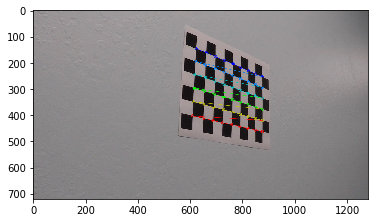

In [50]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os
from moviepy.editor import VideoFileClip

import advanced_lane_lines

%matplotlib qt
%matplotlib inline
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

CAMERA_CALIBRATION_COEFFICIENTS_FILE = './camera_cal/calibrated_data.p'

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        #plt.show()
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
plt.show()

#image_size = (image.shape[1], image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#calibrated_data = {'mtx': mtx, 'dist': dist}
#with open(CAMERA_CALIBRATION_COEFFICIENTS_FILE, 'wb') as f:
#    pickle.dump(calibrated_data, file=f)
            
#cv2.destroyAllWindows()

## And so on and so forth...

Camera calibration logic is encapsulated in `CameraCalibrator` class in the `dvanced_lane_lines.py` module.
The method of this `CameraCalibrator` class is undistort and it takes a distorted image as the input and produces an undistorted image.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


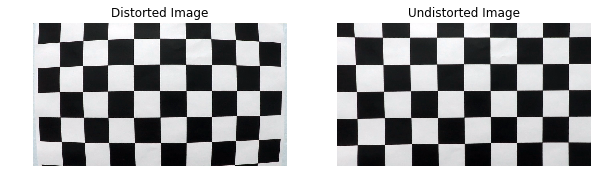

In [52]:
%load_ext autoreload
%autoreload 2

# Take example distorted image and undistort it using saved camera coefficients
distorted_image = './camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = advanced_lane_lines.cal_undistort(distorted_image, mtx, dist)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(distorted_image)


plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image')

plt.show()

In [53]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
undistorted_dest_location = '.\\output_images\\camera_cal\\'
calibration_images = glob.glob('.\\camera_cal\\calibration*.jpg')

for image_file in calibration_images:
    dest_path = os.path.join(undistorted_dest_location , os.path.split(image_file)[1])
    image = cv2.imread(image_file)
    undistorted_image = advanced_lane_lines.cal_undistort(image, mtx, dist)
    # Save undistorted image
    #cv2.imwrite(dest_path, undistorted_image)

## Next, we are going to apply distortion correction to testing images

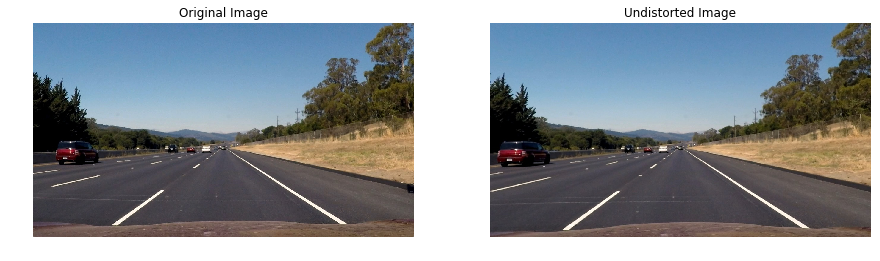

In [69]:
sample_image = './test_images/straight_lines2.jpg'
sample_image = cv2.imread(sample_image)
straight = advanced_lane_lines.cal_undistort(sample_image)

plt.figure(figsize=(15, 9))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(straight, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.axis('off')

plt.show()

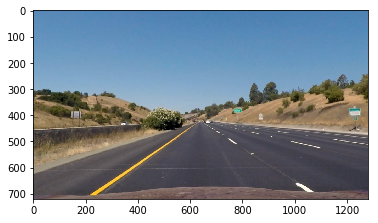

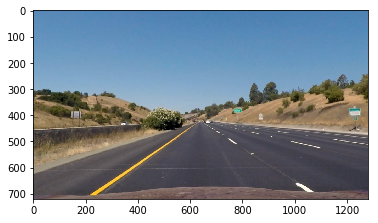

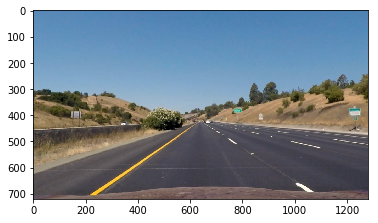

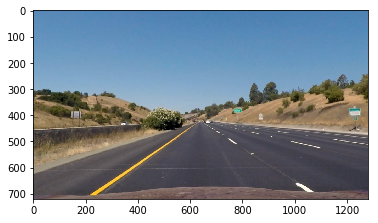

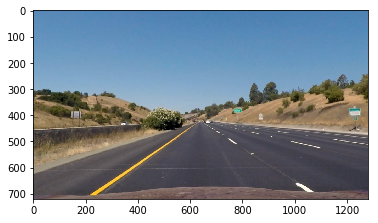

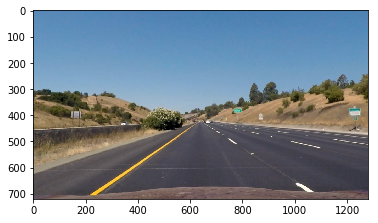

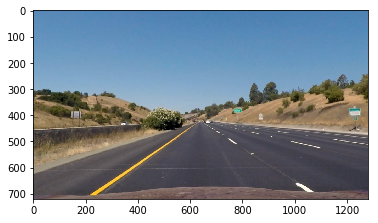

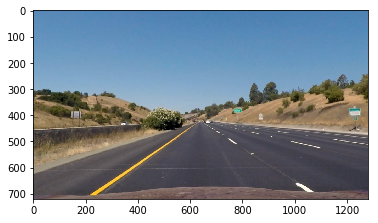

In [88]:
# Next we are going to save distrotion corrected images to 
# ./output_images/test_images_ undistorted folder

undistorted_images = './output_images/undistorted_test_images/'
test_images = './test_images/'
images_test_list = os.listdir(test_images)

for image_name in images_test_list:
    undistorted_test_image = undistorted_images + image_name
    distorted_image = test_images + image_name
    distorted_img = cv2.imread(distorted_image)
    undistorted_test_img = advanced_lane_lines.cal_undistort(distorted_img)
    cv2.imwrite(undistorted_test_image, undistorted_test_img)
    plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
    plt.show()

##  Extracting Lane Line Pixels Using Color Thresholding

In order to identify lane line, we have used three main techniques namely:

1. Sobel operation in X direction
2. Color thresholding in S component of the HLS color space.
3. Color thresholding in L component of the HLS color space.

These three operations are encapsulated in the method called **`binarize`** in **`advanced_lane_finding.py`** module located in **`$PROJECT_HOME/src`** folder.

Also, below shows the `binarize` operation applied to a sample image.

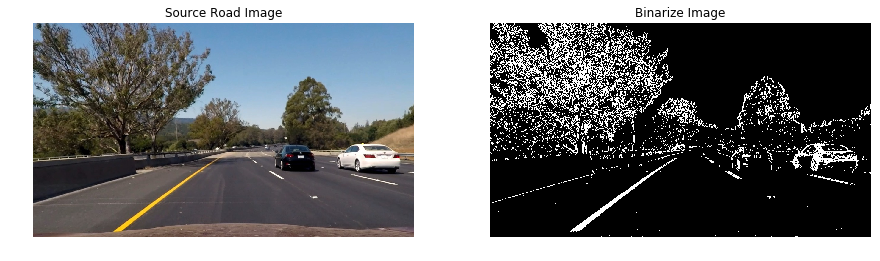

In [100]:
saved_undistorted_img = mpimg.imread('./output_images/undistorted_test_images/test6.jpg')
binary_img = advanced_lane_lines.pipeline(saved_undistorted_img,
                                                 sx_thresh = (20, 255), 
                                                 s_thresh = (170, 255), 
                                                 l_thresh = (30, 255))
plt.figure(figsize=(15, 9))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(saved_undistorted_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Binarize Image')
plt.imshow(binary_img)

plt.show()

In [103]:
# Next we are going to save all binary threshold image to
# ./output_images/test_images_binary folder

OUTPUT_DIR = './output_images/test_images_binary/'
INPUT_DIR = './output_images/undistorted_test_images/'

for file in os.listdir(INPUT_DIR):
    input_undistorted_img = mpimg.imread(INPUT_DIR + file)
    binary_img = advanced_lane_lines.pipeline(input_undistorted_img,
                                                 sx_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
    cv2.imwrite(OUTPUT_DIR + file, binary_img)
print('{} images in directory {}'.format(len(os.listdir(INPUT_DIR)), OUTPUT_DIR))

8 images saved to ./output_images/test_images_binary/ directory


## Perspective Transformation

The second step of the lane line finding pipeline is "perspective transformation" step. In an image perspective is the phenomenon where objects appear smaller the further away they are from a viewpoint.   

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. In the project we are going to use bird’s-eye view transform that allows us to view a lane from above; this will be useful for calculating the lane curvature in step 4.

Warped operation is encapculated in **`PerspectiveTransformer`** class of the **`advanced_lane_lines.py`** package. In order to create an instance of **`PerspectiveTransformer`**  class we need to provide four source and destination points. In order to clearly visible lane lines we have selected following source and destination points. 

|Source Points | Destination Points|
|--------------|-------------------|
|(253, 697)      |    (303, 697)       |
|(585, 456)      |(303, 0)             |
|(700, 456)      |(1011, 0)            |
|(1061, 690)     |(1011, 690)          |

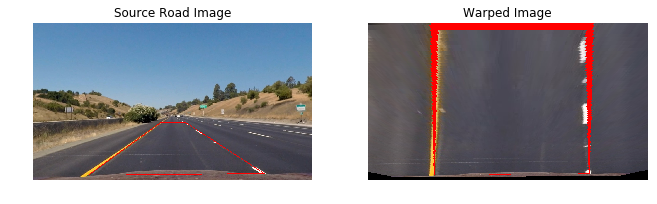

In [129]:
image = mpimg.imread('./output_images/undistorted_test_images/straight_lines1.jpg')

corners = np.float32([[252, 697],[585,456],[700, 456],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

cv2.line(image, (253, 697), (585,456), color=[255,0,0], thickness=2)
cv2.line(image, (585,456), (700, 456), color=[255,0,0], thickness=2)
cv2.line(image, (700, 456), (1061,690), color=[255,0,0], thickness=2)
cv2.line(image, (1061,690), (253, 697), color=[255,0,0], thickness=2)

warped_img = advanced_lane_lines.warper(image, src, dst)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

plt.show()

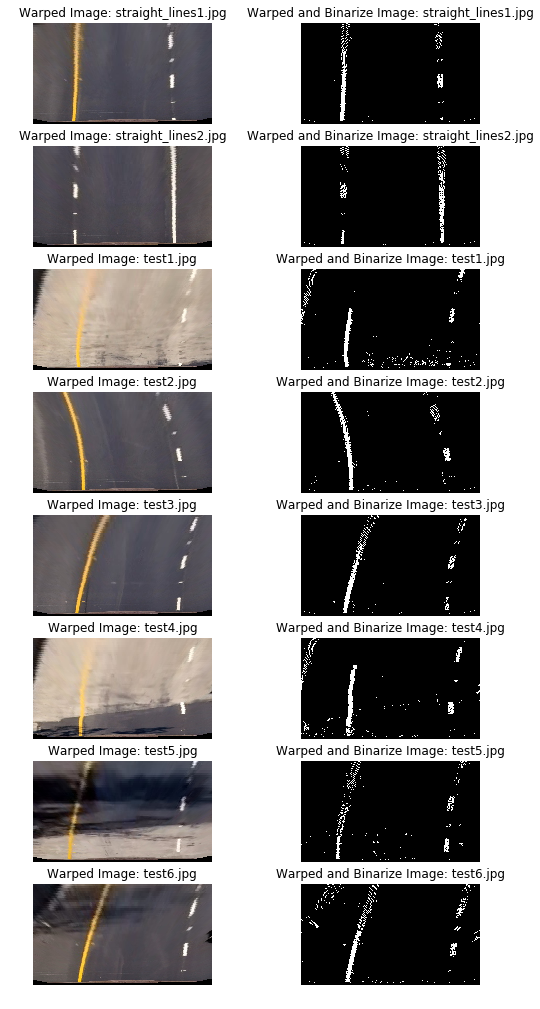

In [135]:
index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

binary_images = []
for file in os.listdir('./output_images/undistorted_test_images/'):
    image = mpimg.imread('./output_images/undistorted_test_images/' + file)
        
    ax1 = plt.subplot(gs[index])
    warped = advanced_lane_lines.warper(image, src, dst)
    ax1.axis('off')
    ax1.set_title('Warped Image: {}'.format(file))
    ax1.imshow(warped)
    index += 1
    
    binary_img = advanced_lane_lines.pipeline(warped)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title('Warped and Binarize Image: {}'.format(file))
    ax2.imshow(binary_img)
    index += 1
    
plt.show()

## 4. Calculating Lane Curvature
Now we have extracted lane line pixels. So next step would be calculating the road curvature and other necessary quantities (such as how much the vehicle off from the center of the lane)

In order to calculate road curvature, we have used two methods as given below.
1. `naive_lane_extractor(self, binary_warped)` (inside the **Line** class in advanced_line_finding module)
2. `smart_lane_extractor(self, binary_warped)` (inside the **Line** class in advanced_line_finding module

Both methods take a binary warped image (similar to one shown above) and produces X coordinates of both left and right lane lines. `naive_lane_extractor(self, binary_warped)` method uses **sliding window** to identify lane lines from the binary warped image and then uses a second order polynomial estimation technique to calculate road curvature. 

In following code blocks, explain the algorith we used in the **`naive_lane_extractor(self, binary_warped)`** method.

* **`naive_lane_extractor(self, binary_warped)`** algorithm expects a binary warped image such as one shown below.

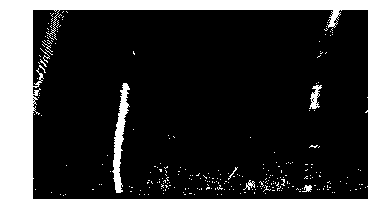

In [144]:
warped_image = binary_images[2] 
plt.imshow(warped_image)
plt.axis('off')
plt.show()

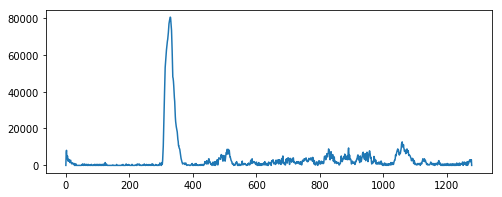

In [145]:
histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()

In [146]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

nwindows = 9
window_height = np.int(warped_image.shape[0] / nwindows)

# Extracts x and y coordinates of non-zero pixels
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set current x coordinated for left and right
leftx_current = leftx_base
rightx_current = rightx_base

margin = 75
min_num_pixels = 35

# save pixel ids in these two lists
left_lane_inds = []
right_lane_inds = []

Peak point of left half: 329
Peak point of right half: 1060


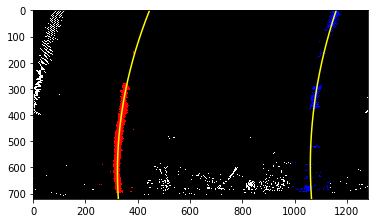

In [147]:
for window in range(nwindows):
    win_y_low = warped_image.shape[0] - (window + 1) * window_height
    win_y_high = warped_image.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the ndarrays of indices
left_lane_array = np.concatenate(left_lane_inds)
right_lane_array = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array]
lefty = nonzeroy[left_lane_array]
rightx = nonzerox[right_lane_array]
righty = nonzeroy[right_lane_array]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]


warped_image[nonzeroy[left_lane_array], nonzerox[left_lane_array]] = [255, 0, 0]
warped_image[nonzeroy[right_lane_array], nonzerox[right_lane_array]] = [0, 0, 255]
plt.imshow(warped_image)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Producing output images and videos with highlighted lane lines

In order to easy work with images as well as videos, we have created a Python class called **`Line`** inside the **`advanced_lane_lines`** module. It encapsulates all the methods we described above and few more helper methods as well.  

The key method of **`Line`** class is **`process(self, image)`** method. It takes a single image as the input. That image goes through the image process pipeline as described above and finally produces another image which contains highlighted lane line, lane line curvature information and the content of the original image.

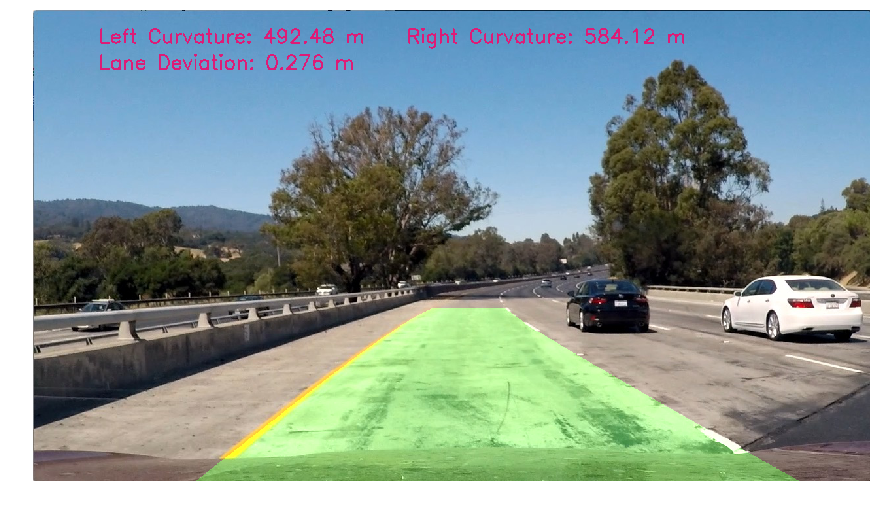

In [166]:
src_image = mpimg.imread('./test_images/test1.jpg')

line = advanced_lane_lines.Line()
output_image = line.process(src_image)

plt.figure(figsize=(15, 9))
plt.axis('off')
plt.imshow(output_image)
plt.show()

In [168]:
output_file = './processed_project_video.mp4'
input_file = './project_video.mp4'
line = advanced_lane_lines.Line()

clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line.process) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:41<00:00,  7.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



In [169]:
output_file = './processed_project_video1.mp4'
input_file = './project_video.mp4'
line = advanced_lane_lines.Line()

clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line.process) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video1.mp4
[MoviePy] Writing video ./processed_project_video1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:48<00:00,  7.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video1.mp4 

